[*********************100%***********************]  1 of 1 completed

Using device: cuda


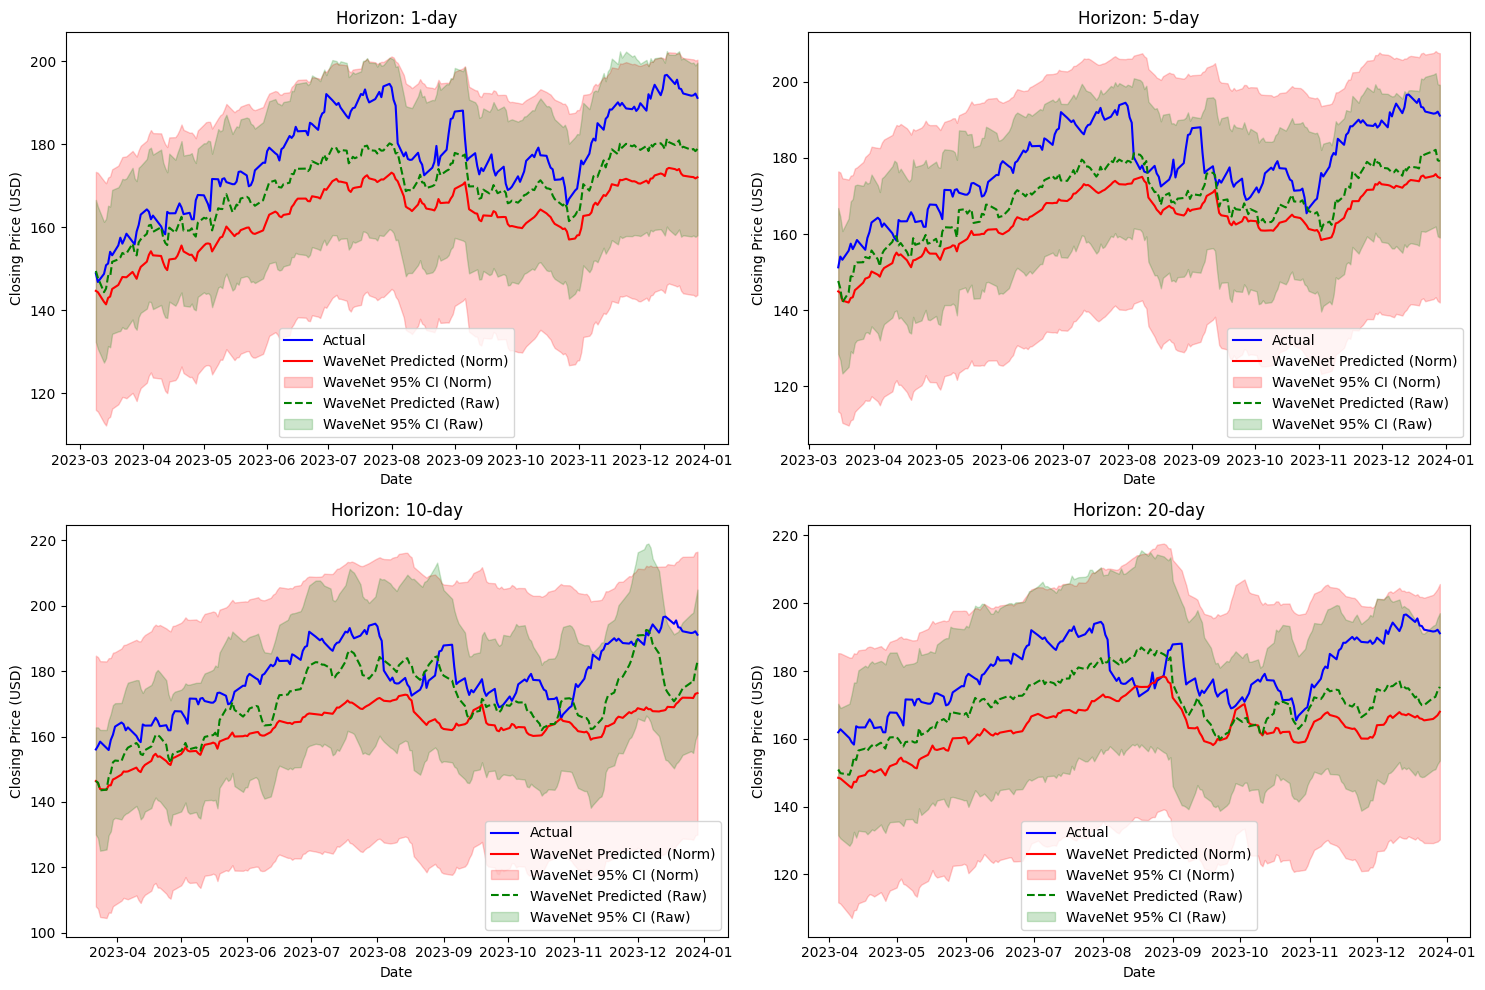

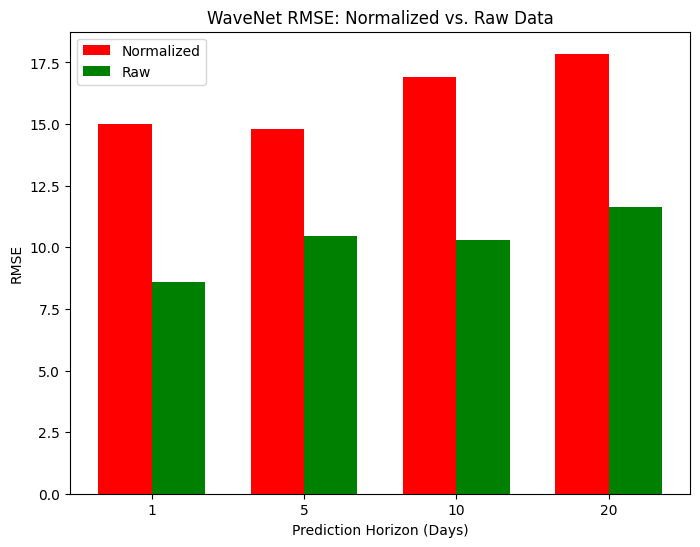

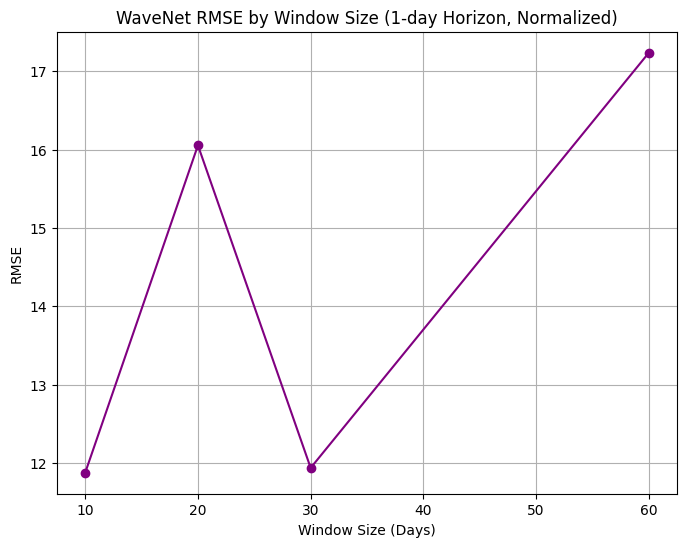

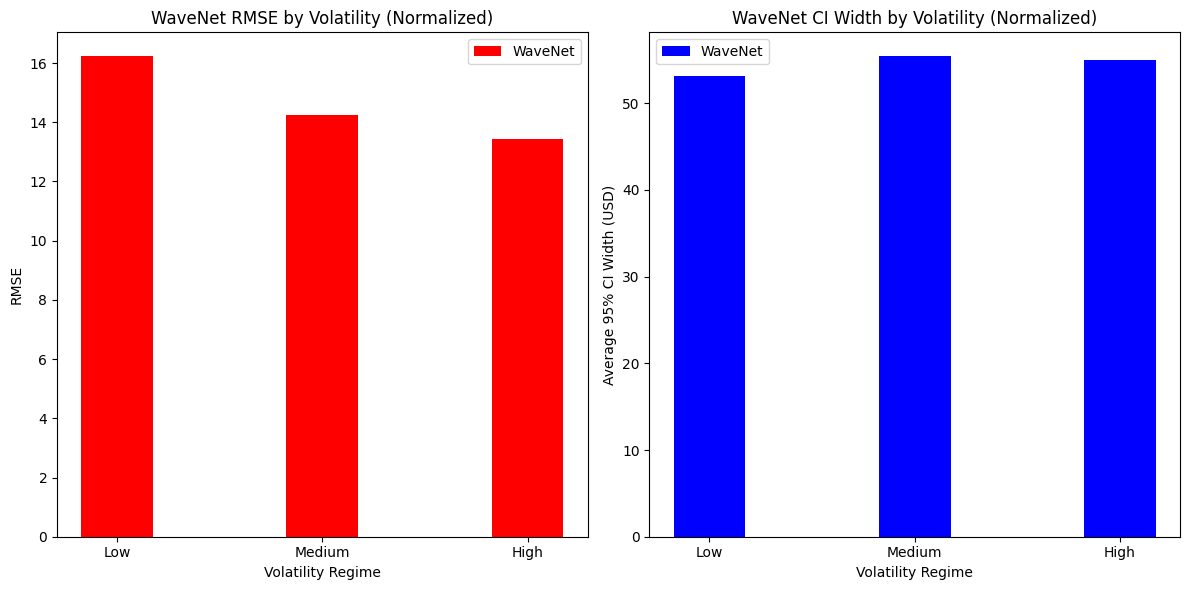

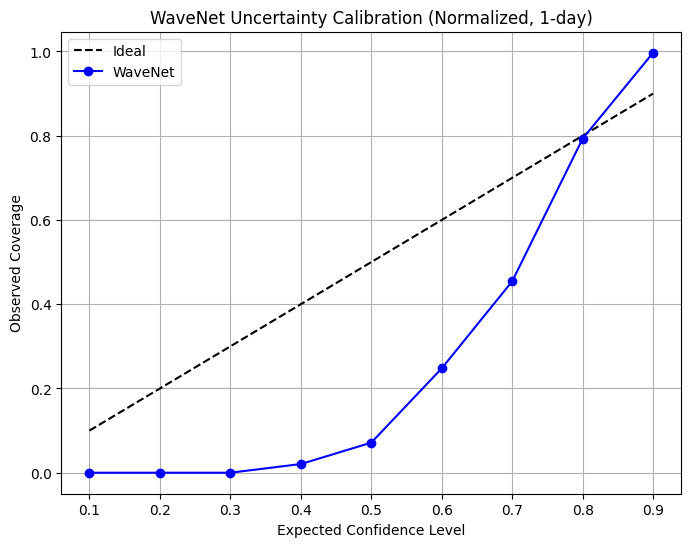

Experiment 1: Normalized vs. Original Data
Raw Data (Scaled):
Horizon 1-day:
WaveNet - RMSE: 8.59, MAE: 7.69
Horizon 5-day:
WaveNet - RMSE: 10.46, MAE: 9.37
Horizon 10-day:
WaveNet - RMSE: 10.30, MAE: 8.87
Horizon 20-day:
WaveNet - RMSE: 11.62, MAE: 10.38

Normalized Data:
Horizon 1-day:
WaveNet - RMSE: 15.00, MAE: 14.34
Horizon 5-day:
WaveNet - RMSE: 14.82, MAE: 13.90
Horizon 10-day:
WaveNet - RMSE: 16.93, MAE: 15.65
Horizon 20-day:
WaveNet - RMSE: 17.86, MAE: 16.22

Experiment 2: Window Sizes (1-day Horizon, Normalized)
Window 10-day: RMSE: 11.88, MAE: 11.15
Window 20-day: RMSE: 16.05, MAE: 15.02
Window 30-day: RMSE: 11.94, MAE: 10.93
Window 60-day: RMSE: 17.24, MAE: 16.71

Experiment 3: Volatility Sensitivity (Normalized, 1-day)
WaveNet RMSE: {'Low': '16.23', 'Medium': '14.25', 'High': '13.43'}
WaveNet CI Width: {'Low': '53.12', 'Medium': '55.41', 'High': '54.97'}

Experiment 4: Uncertainty Calibration (Normalized, 1-day)
Confidence Levels: ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6',

In [10]:
# Cell 1: Imports and Setup
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
import yfinance as yf
import seaborn as sns
from scipy.stats import norm

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Cell 2: Load Real Data from Yahoo Finance
print("Downloading AAPL data from Yahoo Finance")
data = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
data.reset_index(inplace=True)
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['Volatility'] = data['Close'].rolling(window=20).std()
data['Momentum'] = data['Close'].pct_change(periods=5)
data = data.dropna().reset_index(drop=True)

features = ['Close', 'Volume', 'MA5', 'MA20', 'Volatility', 'Momentum']
raw_data = data[features].values
minmax_scaler = MinMaxScaler()
norm_data = minmax_scaler.fit_transform(raw_data)
std_scaler = StandardScaler()
scaled_raw_data = std_scaler.fit_transform(raw_data)

n = len(raw_data)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
train_raw = scaled_raw_data[:n_train]
val_raw = scaled_raw_data[n_train:n_train+n_val]
test_raw = scaled_raw_data[n_train+n_val:]
train_norm = norm_data[:n_train]
val_norm = norm_data[n_train:n_train+n_val]
test_norm = norm_data[n_train+n_val:]
test_dates = data['Date'].iloc[n_train+n_val+20:]

# Cell 3: Create Sequences
def create_sequences(data, seq_length, horizon=1):
    X, y = [], []
    for i in range(len(data) - seq_length - horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length+horizon-1, 0])
    return np.array(X), np.array(y)

# Cell 4: WaveNet Block Definition
class WaveNetBlock(nn.Module):
    def __init__(self, filters, dilation_rate):
        super(WaveNetBlock, self).__init__()
        self.dilation_rate = dilation_rate
        self.kernel_size = 2
        self.padding = (self.kernel_size - 1) * dilation_rate
        self.conv = nn.Conv1d(filters, filters, kernel_size=self.kernel_size, padding=self.padding, dilation=dilation_rate)
        self.gate = nn.Conv1d(filters, filters, kernel_size=self.kernel_size, padding=self.padding, dilation=dilation_rate)
        self.residual = nn.Conv1d(filters, filters, kernel_size=1)
        self.skip = nn.Conv1d(filters, filters, kernel_size=1)
    
    def forward(self, x):
        z = torch.tanh(self.conv(x)) * torch.sigmoid(self.gate(x))
        z = z[:, :, :x.size(2)]
        residual = self.residual(x) + z
        skip = self.skip(z)
        return residual, skip

# Cell 5: Skip Connection Layer
class SkipConnectionLayer(nn.Module):
    def __init__(self):
        super(SkipConnectionLayer, self).__init__()
    
    def forward(self, skips):
        if not isinstance(skips, list):
            raise ValueError("Expected list of tensors")
        skips_stacked = torch.stack(skips, dim=0)
        out = torch.sum(skips_stacked, dim=0)
        out = out[:, :, -1]
        return out

# Cell 6: Probabilistic WaveNet Model
class ProbabilisticWaveNet(nn.Module):
    def __init__(self, seq_length, n_features, filters=64, num_layers=5):
        super(ProbabilisticWaveNet, self).__init__()
        self.input_conv = nn.Conv1d(n_features, filters, kernel_size=1)
        self.wavenet_blocks = nn.ModuleList([WaveNetBlock(filters, 2**i) for i in range(num_layers)])
        self.skip_connection = SkipConnectionLayer()
        self.dense = nn.Linear(filters, filters)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.mu = nn.Linear(filters, 1)
        self.log_sigma = nn.Linear(filters, 1)
        nn.init.xavier_uniform_(self.mu.weight)
        nn.init.xavier_uniform_(self.log_sigma.weight)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.input_conv(x)
        skips = []
        for block in self.wavenet_blocks:
            x, skip = block(x)
            skips.append(skip)
        out = self.skip_connection(skips)
        out = self.relu(self.dense(out))
        out = self.dropout(out)
        mu = self.mu(out)
        log_sigma = self.log_sigma(out)
        sigma = torch.exp(log_sigma + 1e-6)  # Small offset to avoid log(0)
        return torch.cat([mu, sigma], dim=1)

# Cell 7: Hybrid Loss Function
def hybrid_loss(y_true, y_pred, alpha=0.5):
    mu, sigma = y_pred[:, 0:1], y_pred[:, 1:2]
    dist = Normal(mu, sigma)
    nll = -dist.log_prob(y_true.unsqueeze(1)).mean()
    mse = nn.MSELoss()(mu, y_true.unsqueeze(1))
    return nll + alpha * mse

# Cell 8: Training Function
def train_model(model, X_train, y_train, X_val, y_val, loss_fn, epochs=100, batch_size=64):
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)),
        batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_val).to(device), torch.FloatTensor(y_val).to(device)),
        batch_size=batch_size
    )
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_batch, y_pred)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = loss_fn(y_batch, y_pred)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        
        scheduler.step(val_loss)

# Cell 9: Evaluation Function
def evaluate_model(model, X_test, y_test, scaler=None, test_dates=None, is_normalized=False):
    model.eval()
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    with torch.no_grad():
        y_pred = model(X_test_tensor)
    mu_pred, sigma_pred = y_pred[:, 0:1], y_pred[:, 1:2]
    mu_pred = mu_pred.cpu().numpy()
    sigma_pred = sigma_pred.cpu().numpy()
    
    if is_normalized and scaler is not None:
        y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), len(features)-1))]))[:, 0]
        mu_pred_inv = scaler.inverse_transform(np.hstack([mu_pred, np.zeros((len(mu_pred), len(features)-1))]))[:, 0]
        sigma_inv = sigma_pred * (scaler.data_max_[0] - scaler.data_min_[0])
    else:
        y_test_inv = std_scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), len(features)-1))]))[:, 0]
        mu_pred_inv = std_scaler.inverse_transform(np.hstack([mu_pred, np.zeros((len(mu_pred), len(features)-1))]))[:, 0]
        sigma_inv = sigma_pred * std_scaler.scale_[0]  # Adjust sigma for StandardScaler
    
    rmse = np.sqrt(mean_squared_error(y_test_inv, mu_pred_inv))
    mae = mean_absolute_error(y_test_inv, mu_pred_inv)
    return {
        'y_test_inv': y_test_inv,
        'mu_pred_inv': mu_pred_inv,
        'sigma_inv': sigma_inv,
        'rmse': rmse,
        'mae': mae
    }

# Cell 10: Experiment 1 - Normalized vs. Original Data across Prediction Horizons
horizons = [1, 5, 10, 20]
results_raw = {'WaveNet': {}}
results_norm = {'WaveNet': {}}
seq_length = 20

for horizon in horizons:
    X_train_raw, y_train_raw = create_sequences(train_raw, seq_length, horizon)
    X_val_raw, y_val_raw = create_sequences(val_raw, seq_length, horizon)
    X_test_raw, y_test_raw = create_sequences(test_raw, seq_length, horizon)
    test_dates_horizon = test_dates[horizon-1:len(y_test_raw)+horizon-1]
    
    wavenet_model = ProbabilisticWaveNet(seq_length, len(features)).to(device)
    train_model(wavenet_model, X_train_raw, y_train_raw, X_val_raw, y_val_raw, lambda y, p: hybrid_loss(y, p, alpha=0.5))
    wavenet_results = evaluate_model(wavenet_model, X_test_raw, y_test_raw, is_normalized=False)
    results_raw['WaveNet'][horizon] = wavenet_results
    
    X_train_norm, y_train_norm = create_sequences(train_norm, seq_length, horizon)
    X_val_norm, y_val_norm = create_sequences(val_norm, seq_length, horizon)
    X_test_norm, y_test_norm = create_sequences(test_norm, seq_length, horizon)
    
    wavenet_model = ProbabilisticWaveNet(seq_length, len(features)).to(device)
    train_model(wavenet_model, X_train_norm, y_train_norm, X_val_norm, y_val_norm, lambda y, p: hybrid_loss(y, p, alpha=0.5))
    wavenet_results = evaluate_model(wavenet_model, X_test_norm, y_test_norm, minmax_scaler, test_dates_horizon, is_normalized=True)
    results_norm['WaveNet'][horizon] = wavenet_results

# Cell 11: Visualization - Prediction Horizons (Normalized and Raw)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for idx, horizon in enumerate(horizons):
    ax = axes[idx]
    test_dates_horizon = test_dates[horizon-1:len(results_norm['WaveNet'][horizon]['y_test_inv'])+horizon-1]
    ax.plot(test_dates_horizon, results_norm['WaveNet'][horizon]['y_test_inv'], label='Actual', color='blue')
    ax.plot(test_dates_horizon, results_norm['WaveNet'][horizon]['mu_pred_inv'], label='WaveNet Predicted (Norm)', color='red')
    ax.fill_between(test_dates_horizon,
                    results_norm['WaveNet'][horizon]['mu_pred_inv'] - 2 * results_norm['WaveNet'][horizon]['sigma_inv'].flatten(),
                    results_norm['WaveNet'][horizon]['mu_pred_inv'] + 2 * results_norm['WaveNet'][horizon]['sigma_inv'].flatten(),
                    color='red', alpha=0.2, label='WaveNet 95% CI (Norm)')
    ax.plot(test_dates_horizon, results_raw['WaveNet'][horizon]['mu_pred_inv'], label='WaveNet Predicted (Raw)', color='green', linestyle='--')
    ax.fill_between(test_dates_horizon,
                    results_raw['WaveNet'][horizon]['mu_pred_inv'] - 2 * results_raw['WaveNet'][horizon]['sigma_inv'].flatten(),
                    results_raw['WaveNet'][horizon]['mu_pred_inv'] + 2 * results_raw['WaveNet'][horizon]['sigma_inv'].flatten(),
                    color='green', alpha=0.2, label='WaveNet 95% CI (Raw)')
    ax.set_title(f'Horizon: {horizon}-day')
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price (USD)')
    ax.legend()
plt.tight_layout()
plt.show()

# Cell 12: Visualization - Normalized vs. Raw RMSE
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
index = np.arange(len(horizons))
rmse_norm = [results_norm['WaveNet'][h]['rmse'] for h in horizons]
rmse_raw = [results_raw['WaveNet'][h]['rmse'] for h in horizons]
ax.bar(index, rmse_norm, bar_width, label='Normalized', color='red')
ax.bar(index + bar_width, rmse_raw, bar_width, label='Raw', color='green')
ax.set_xlabel('Prediction Horizon (Days)')
ax.set_ylabel('RMSE')
ax.set_title('WaveNet RMSE: Normalized vs. Raw Data')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(horizons)
ax.legend()
plt.show()

# Cell 13: Experiment 2 - Different Window Sizes
window_sizes = [10, 20, 30, 60]
results_window = {}
horizon = 1

for seq_length in window_sizes:
    X_train_norm, y_train_norm = create_sequences(train_norm, seq_length, horizon)
    X_val_norm, y_val_norm = create_sequences(val_norm, seq_length, horizon)
    X_test_norm, y_test_norm = create_sequences(test_norm, seq_length, horizon)
    
    wavenet_model = ProbabilisticWaveNet(seq_length, len(features)).to(device)
    train_model(wavenet_model, X_train_norm, y_train_norm, X_val_norm, y_val_norm, lambda y, p: hybrid_loss(y, p, alpha=0.5))
    wavenet_results = evaluate_model(wavenet_model, X_test_norm, y_test_norm, minmax_scaler, is_normalized=True)
    results_window[seq_length] = wavenet_results

# Cell 14: Visualization - Window Size Impact
fig, ax = plt.subplots(figsize=(8, 6))
rmse_window = [results_window[w]['rmse'] for w in window_sizes]
ax.plot(window_sizes, rmse_window, marker='o', color='purple')
ax.set_xlabel('Window Size (Days)')
ax.set_ylabel('RMSE')
ax.set_title('WaveNet RMSE by Window Size (1-day Horizon, Normalized)')
ax.grid(True)
plt.show()

# Cell 15: Experiment 3 - Volatility Sensitivity
test_volatility = test_raw[:, features.index('Volatility')]
quantiles = np.quantile(test_volatility[seq_length:], [0.33, 0.66])
low_vol_idx = test_volatility[seq_length:] <= quantiles[0]
med_vol_idx = (test_volatility[seq_length:] > quantiles[0]) & (test_volatility[seq_length:] <= quantiles[1])
high_vol_idx = test_volatility[seq_length:] > quantiles[1]

X_test_norm, y_test_norm = create_sequences(test_norm, seq_length, horizon=1)
wavenet_model = ProbabilisticWaveNet(seq_length, len(features)).to(device)
train_model(wavenet_model, *create_sequences(train_norm, seq_length, 1), *create_sequences(val_norm, seq_length, 1), lambda y, p: hybrid_loss(y, p, alpha=0.5))
wavenet_results = evaluate_model(wavenet_model, X_test_norm, y_test_norm, minmax_scaler, is_normalized=True)

vol_results = {
    'WaveNet': {
        'Low': np.sqrt(mean_squared_error(wavenet_results['y_test_inv'][low_vol_idx], wavenet_results['mu_pred_inv'][low_vol_idx])),
        'Medium': np.sqrt(mean_squared_error(wavenet_results['y_test_inv'][med_vol_idx], wavenet_results['mu_pred_inv'][med_vol_idx])),
        'High': np.sqrt(mean_squared_error(wavenet_results['y_test_inv'][high_vol_idx], wavenet_results['mu_pred_inv'][high_vol_idx]))
    },
    'CI_Width': {
        'Low': np.mean(4 * wavenet_results['sigma_inv'][low_vol_idx]),
        'Medium': np.mean(4 * wavenet_results['sigma_inv'][med_vol_idx]),
        'High': np.mean(4 * wavenet_results['sigma_inv'][high_vol_idx])
    }
}

# Cell 16: Visualization - Volatility Sensitivity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
bar_width = 0.35
index = np.arange(3)
rmse_vol = [vol_results['WaveNet']['Low'], vol_results['WaveNet']['Medium'], vol_results['WaveNet']['High']]
ci_width = [vol_results['CI_Width']['Low'], vol_results['CI_Width']['Medium'], vol_results['CI_Width']['High']]
ax1.bar(index, rmse_vol, bar_width, label='WaveNet', color='red')
ax1.set_xlabel('Volatility Regime')
ax1.set_ylabel('RMSE')
ax1.set_title('WaveNet RMSE by Volatility (Normalized)')
ax1.set_xticks(index)
ax1.set_xticklabels(['Low', 'Medium', 'High'])
ax1.legend()

ax2.bar(index, ci_width, bar_width, label='WaveNet', color='blue')
ax2.set_xlabel('Volatility Regime')
ax2.set_ylabel('Average 95% CI Width (USD)')
ax2.set_title('WaveNet CI Width by Volatility (Normalized)')
ax2.set_xticks(index)
ax2.set_xticklabels(['Low', 'Medium', 'High'])
ax2.legend()
plt.tight_layout()
plt.show()

# Cell 17: Experiment 4 - Uncertainty Calibration
confidence_levels = np.linspace(0.1, 0.9, 9)
coverage = []
for cl in confidence_levels:
    z = norm.ppf(1 - (1 - cl) / 2)
    lower = wavenet_results['mu_pred_inv'] - z * wavenet_results['sigma_inv']
    upper = wavenet_results['mu_pred_inv'] + z * wavenet_results['sigma_inv']
    covered = np.mean((wavenet_results['y_test_inv'] >= lower) & (wavenet_results['y_test_inv'] <= upper))
    coverage.append(covered)

# Cell 18: Visualization - Uncertainty Calibration
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(confidence_levels, confidence_levels, linestyle='--', color='black', label='Ideal')
ax.plot(confidence_levels, coverage, marker='o', color='blue', label='WaveNet')
ax.set_xlabel('Expected Confidence Level')
ax.set_ylabel('Observed Coverage')
ax.set_title('WaveNet Uncertainty Calibration (Normalized, 1-day)')
ax.legend()
ax.grid(True)
plt.show()

# Cell 19: Print Results
print('Experiment 1: Normalized vs. Original Data')
print('Raw Data (Scaled):')
for horizon in horizons:
    print(f'Horizon {horizon}-day:')
    print(f'WaveNet - RMSE: {results_raw["WaveNet"][horizon]["rmse"]:.2f}, MAE: {results_raw["WaveNet"][horizon]["mae"]:.2f}')
print('\nNormalized Data:')
for horizon in horizons:
    print(f'Horizon {horizon}-day:')
    print(f'WaveNet - RMSE: {results_norm["WaveNet"][horizon]["rmse"]:.2f}, MAE: {results_norm["WaveNet"][horizon]["mae"]:.2f}')

print('\nExperiment 2: Window Sizes (1-day Horizon, Normalized)')
for window in window_sizes:
    print(f'Window {window}-day: RMSE: {results_window[window]["rmse"]:.2f}, MAE: {results_window[window]["mae"]:.2f}')

print('\nExperiment 3: Volatility Sensitivity (Normalized, 1-day)')
print('WaveNet RMSE:', {k: f'{v:.2f}' for k, v in vol_results['WaveNet'].items()})
print('WaveNet CI Width:', {k: f'{v:.2f}' for k, v in vol_results['CI_Width'].items()})

print('\nExperiment 4: Uncertainty Calibration (Normalized, 1-day)')
print('Confidence Levels:', [f'{cl:.1f}' for cl in confidence_levels])
print('Coverage:', [f'{c:.2f}' for c in coverage])